# Prueba Contaminación de Madrid

Vamos a comenzar importando los paquetes:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from scipy.stats import f_oneway


A continuación almacenamos los datos correspondientes al año 2018 en un data frame que

In [2]:
ruta = 'Datos/Calidad_aire_mes/'
df_pollution = pd.DataFrame()

for file in os.listdir(ruta):
    df_file = pd.read_csv(ruta + file, sep=';')
    df_pollution = pd.concat([df_pollution, df_file], ignore_index = True)

df_pollution.head()


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2018,4,1,2.0,V,...,2.0,V,2.0,V,3.0,V,4.0,V,3.0,V
1,28,79,4,1,28079004_1_38,2018,4,2,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
2,28,79,4,1,28079004_1_38,2018,4,3,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2018,4,4,2.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
4,28,79,4,1,28079004_1_38,2018,4,5,2.0,V,...,2.0,V,2.0,V,4.0,V,5.0,V,4.0,V


Cargamos los data frames correspondientes a los datos de las estaciones y las temperaturas.

In [3]:
df_stations = pd.read_csv('Datos/madrid_air_quality_stations.csv')
df_temperatures = pd.read_csv('Datos/madrid_hourly_temperatures_2018.csv')

Nos quedamos con los únicos valores que nos interesan, los correspondientes a los niveles de $NO_2$. Tal y como pone en la documentación de los datos, serán los correspondientes al código de magnitud 8.

In [4]:
df_pollution = df_pollution[df_pollution['MAGNITUD'] == 8].reset_index(drop = True)

Veamos si hay valores vacíos o Nan en nuestro data_frame:

In [5]:
df_pollution.isnull().sum()

PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
H01               0
V01               0
H02               0
V02               0
H03               0
V03               0
H04               0
V04               0
H05               0
V05               0
H06               0
V06               0
H07               0
V07               0
H08               0
V08               0
H09               0
V09               0
H10               0
V10               0
H11               0
V11               0
H12               0
V12               0
H13               0
V13               0
H14               0
V14               0
H15               0
V15               0
H16               0
V16               0
H17               0
V17               0
H18               0
V18               0
H19               0
V19               0
H20               0
V20               0
H21               0
V21               0


In [6]:
df_pollution.isna().sum()

PROVINCIA         0
MUNICIPIO         0
ESTACION          0
MAGNITUD          0
PUNTO_MUESTREO    0
ANO               0
MES               0
DIA               0
H01               0
V01               0
H02               0
V02               0
H03               0
V03               0
H04               0
V04               0
H05               0
V05               0
H06               0
V06               0
H07               0
V07               0
H08               0
V08               0
H09               0
V09               0
H10               0
V10               0
H11               0
V11               0
H12               0
V12               0
H13               0
V13               0
H14               0
V14               0
H15               0
V15               0
H16               0
V16               0
H17               0
V17               0
H18               0
V18               0
H19               0
V19               0
H20               0
V20               0
H21               0
V21               0


Viendo que la tabla está completa, vamos a proceder sustituyendo los valores no válidos para los niveles de dióxido de nitrógeno por la media del los dos valores válidos más próximos a esa hora, uno anterior y otro posterior.


In [7]:
for i in range(1, 25):
    h_col = f'H{i:02d}'
    v_col = f'V{i:02d}'

    n_rows = df_pollution[df_pollution[v_col] == 'N'].index

    for row in n_rows:
        prev_index, prev_row = i, row
        next_index, next_row = i, row

        while df_pollution.at[prev_row, f'V{prev_index:02d}'] == 'N':
            prev_index = (prev_index - 1) if prev_index != 1 else 24
            prev_row = prev_row - 1 if prev_index == 24 else prev_row

        while df_pollution.at[next_row, f'V{next_index:02d}'] == 'N':
            next_index = (next_index + 1) if next_index != 24 else 1
            next_row = next_row + 1 if next_index == 1 else next_row

        mean_value = (df_pollution.at[prev_row, f'H{prev_index:02d}'] + df_pollution.at[next_row, f'H{next_index:02d}']) / 2

        df_pollution.at[row, h_col] = mean_value

Una vez habiendo sustituido los valores no válidos, elimimamos las columnas con el código de validación horaria, ya que no las necesitamos ya.

In [8]:
drop_columns = [f'V{i:02d}' for i in range(1,25)]
df_pollution = df_pollution.drop(drop_columns, axis = 1)

Vamos a añadir a la primera tabla, los datos correspondientes a las temperaturas.

In [9]:
for i in range(1,25): df_pollution[f'T{i:02d}'] = None

for index, row in df_temperatures.iterrows():
    
    date = list(map(int, row['date'].split('-')))
    
    if (row['hour'] == 0):
        
        actual_date= datetime(*date)

        
        day_before = actual_date - timedelta(days=1)

        condition = (df_pollution['MES'] == day_before.month) & (df_pollution['DIA'] == day_before.day)
        column_name = 'T24'
        
    else:

        condition = (df_pollution['MES'] == date[1]) & (df_pollution['DIA'] == date[2])
        column_name = f'T{row["hour"]:02d}'

    df_pollution.loc[condition, column_name] = row['temp']

Modificamos el formato de los datos en la columna _station_ de la tabla _df\_stations_ con el objetivo de emplear esta variable como identificador en la unión de tablas junto a _df\_pollution_.

In [10]:
fun_suffix_add = lambda x: x % 100
df_stations['station'] = df_stations['station'].apply(fun_suffix_add) 

Unimos ambas tablas, eliminamos columnas repetidas y cambiamos los nombres de las columnas para que tengan el mismo formato:

In [11]:
df_pollution = pd.merge(df_pollution, df_stations, how = 'left', left_on = 'ESTACION', right_on = 'station')

df_pollution = df_pollution.drop('station', axis = 1)

df_pollution = df_pollution.rename(columns = {'area' : 'AREA', 'name' : 'NOMBRE', 'address' : 'DIRECCION', 
                                                      'altitude' : 'ALTITUD', 'type' : 'TIPO', 'longitude' : 'LONGITUD',
                                                      'latitude' : 'LATITUD'})
df_pollution.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,H02,...,T22,T23,T24,AREA,NOMBRE,DIRECCION,ALTITUD,TIPO,LONGITUD,LATITUD
0,28,79,4,8,28079004_8_8,2018,4,1,21.0,19.0,...,11.2,10.2,11.8,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,28,79,4,8,28079004_8_8,2018,4,2,67.0,45.0,...,13.2,13.4,12.2,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,28,79,4,8,28079004_8_8,2018,4,3,14.0,9.0,...,11.8,10.7,9.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,28,79,4,8,28079004_8_8,2018,4,4,8.0,3.0,...,11.3,10.5,9.6,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,28,79,4,8,28079004_8_8,2018,4,5,20.0,23.0,...,10.8,9.7,9.4,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


Con los datos ya preparados, veamos que clase de dependencia pueden tener las variables numéricas

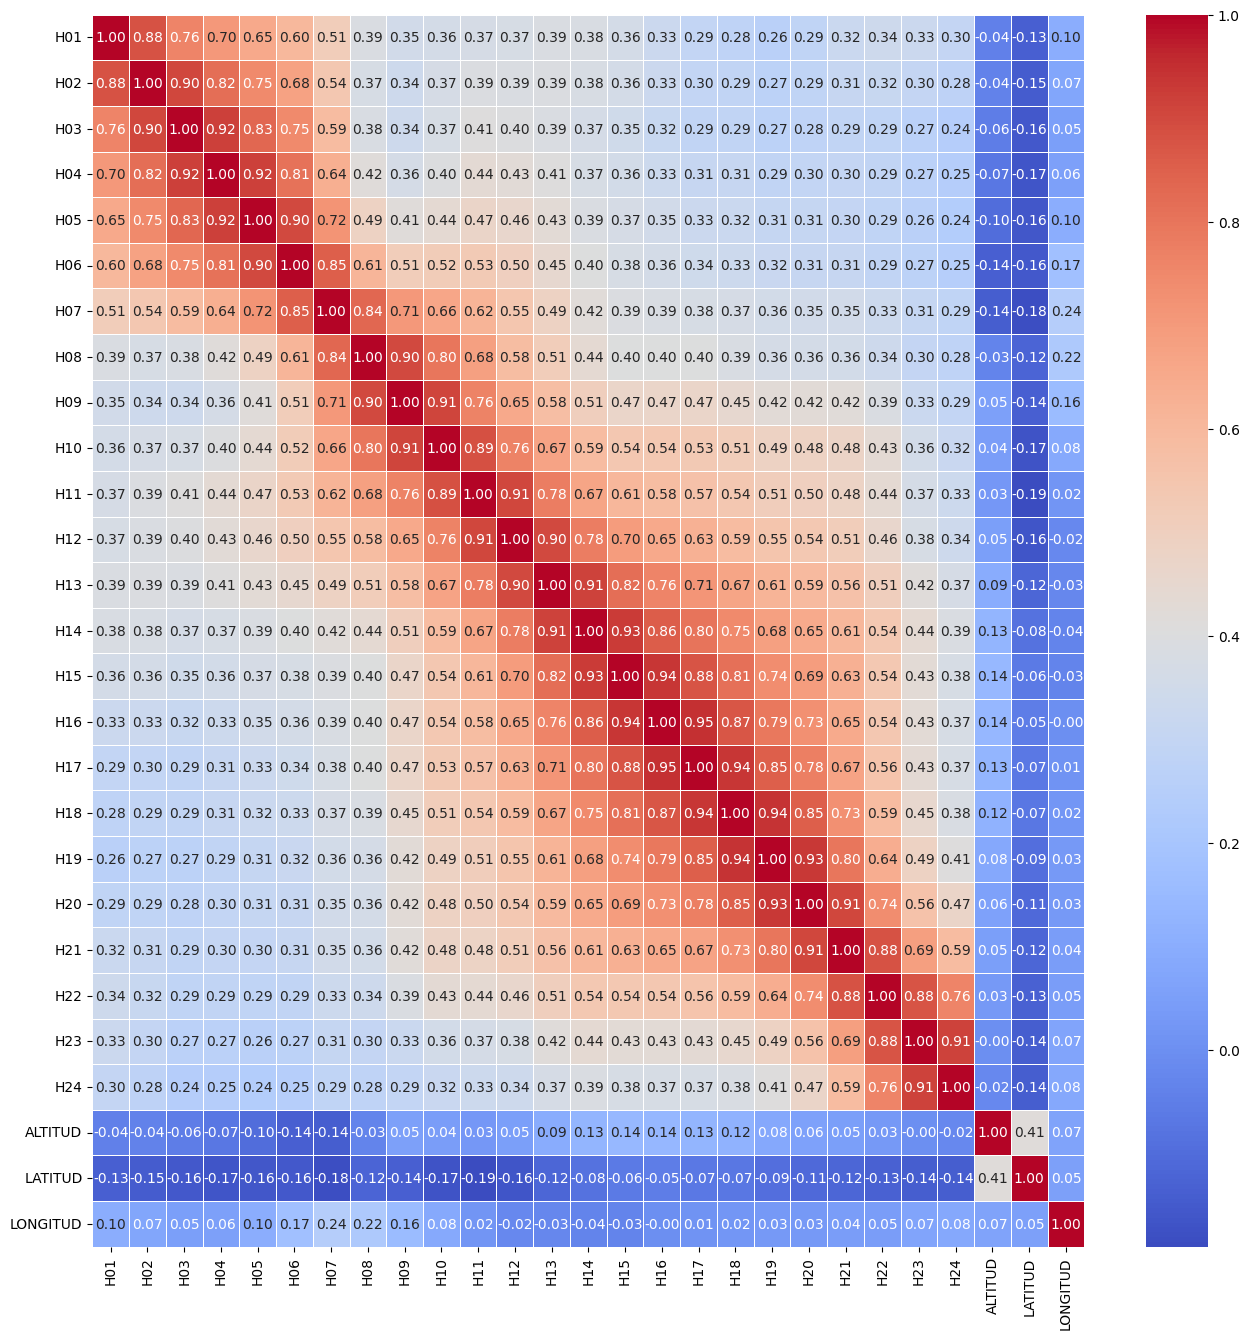

In [12]:
plt.figure(figsize=(16,16))
v_variables = [f'H{i:02d}' for i in range(1,25)] + ['ALTITUD', 'LATITUD', 'LONGITUD']
sns.heatmap(df_pollution.loc[:,v_variables].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

Como era de esperar, las concentraciones son mayormente dependientes entre sí cuando las horas se encuentran más próximas, y menos a horas más lejanas. Esto apunta a que los datos tomados son coherentes.

Por otro lado, no se aprecia una fuerte correlación entre la altitud, la latitud y la longitud con respecto a las concentraciones de $NO_2$.

In [13]:

v_variables = [f'T{i:02d}' for i in range(1,25)]
v_variables.insert(0, 'H12')
print(df_pollution.loc[:,v_variables].corr().iloc[0,:])


H12    1.000000
T01   -0.279962
T02   -0.290514
T03   -0.295710
T04   -0.307261
T05   -0.312203
T06   -0.312186
T07   -0.313607
T08   -0.302544
T09   -0.285596
T10   -0.256177
T11   -0.223000
T12   -0.196658
T13   -0.180142
T14   -0.169411
T15   -0.166866
T16   -0.168346
T17   -0.181033
T18   -0.193154
T19   -0.199530
T20   -0.204515
T21   -0.214800
T22   -0.222050
T23   -0.228028
T24   -0.232131
Name: H12, dtype: float64


Estudiando las posibles relaciones de la temperatura con los niveles de $NO_2$, vemos que los valores a todas horas del día son inversamente proporcionales con respecto a las cantidades de este gas de una forma un poco sutil. Altos niveles de $NO_2$ se relacionan con temperaturas un poco más bajas.

Este análisis de dependencia se podría extender al caso no lineal utilizando el coeficiente de Spearman o gráficos de dispersión para la detección de este tipo de patrones.

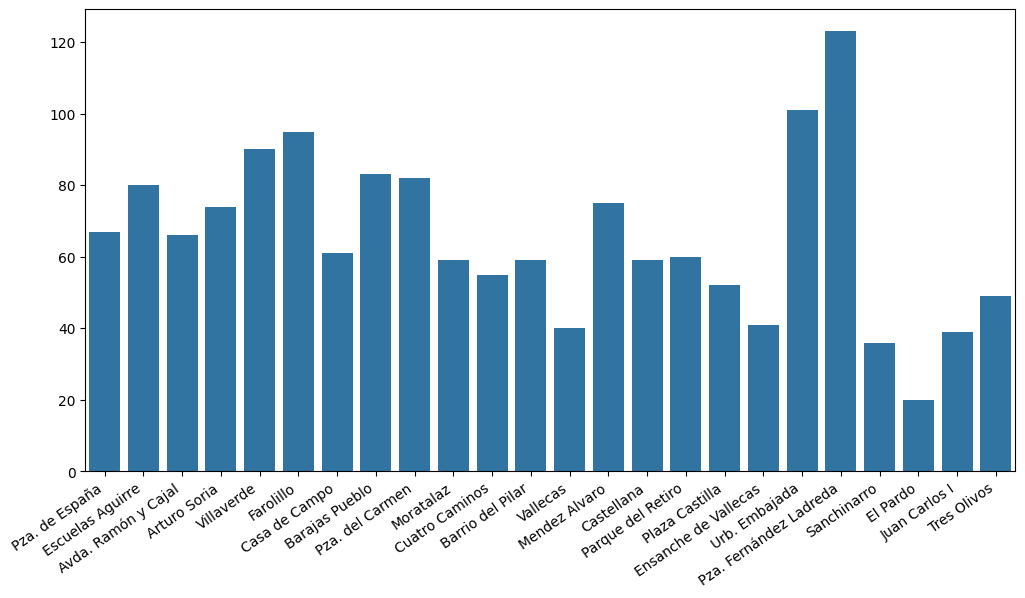

In [14]:


def hour_level_grapgh(df_data, day, month, hour):
    df_level = df_data[(df_data['DIA'] == day) & (df_pollution['MES'] == month)]

    plt.figure(figsize=(12, 6))


    sns.barplot(x=df_level['NOMBRE'].values, y=df_level[f'H{hour:02d}'].values)

    plt.xticks(rotation=35, ha="right", fontsize=10) 
    plt.show()

hour_level_grapgh(df_pollution, 2, 4, 1)

Mirando esta gráfica de las concentraciones de dióxido de nitrógeno a una determinada hora en las diferentes estaciones, se aprecia como sus niveles cambian dependiendo de la ubicación de donde se tome la medida. Luego es posible que haya una dependencia de estos niveles dependiendo de la ubicación de la medición en Madrid. Previamente habíamos visto que las variables latitud, longitud y altitud no impactaban considerablemente en el valor de los niveles del gas, pero es posible que intervengan otras condiciones que no hemos considerado: como si es día laborable o no, el clima, el nivel de tráfico en la zona, etc.

Mirando como evolucionan, en los diferentes puntos, las concentraciones del gas a lo largo del día, obtenemos la siguiente gráfica:

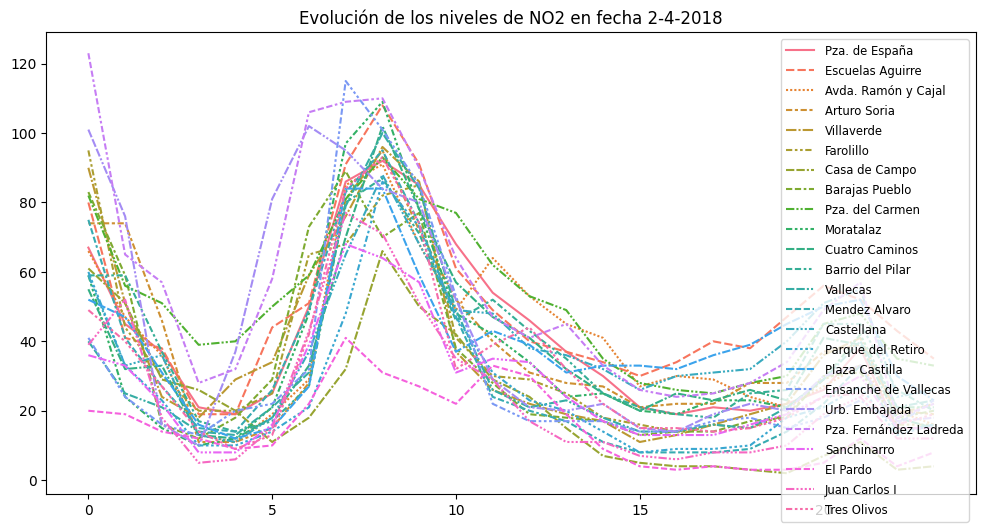

In [15]:


def dayly_growing_chart(df_data, day, month):
    df_growing = df_data[(df_data['MES'] == month) & (df_data['DIA'] == day)].reset_index(drop = True)
    plt.figure(figsize=(12, 6))

    ax = sns.lineplot( data = df_growing.loc[:,'H01':'H24'].values.tolist())
    for i, v_month in enumerate(ax.get_legend().texts):
        v_month.set_text( df_growing["NOMBRE"].values[i])
        v_month.set_fontsize('small')
    
    plt.title(f'Evolución de los niveles de NO2 en fecha {day}-{month}-2018')
    plt.show()

dayly_growing_chart(df_pollution, 2 ,4)


Se puede apreciar como dependiendo de la hora del día, los niveles de $NO_2$ varían en las distintas estaciones. Para el día 2 de abril de 2018, los niveles disminuyen durante las primeras horas de la madrugada, luego aumentan a primeras horas de la mañana alcanzando el pico sobre las 9 de la mañana (exceptuando en la estación del El Pardo). Para finalizar estabilizándose a niveles bajos en lo que queda del día.

Para plantear un modelo de predicción a tres días de los niveles de $NO_2$ haría lo siguiente:
- De todas las variables consideradas a lo largo del estudio tomaría una predicción de las temperaturas para dentro de 3 días, ya que presentaban una incidencia a considerar en los niveles del gas (independiente del momento horario en el que estaban medidas). También se podrían considerar la hora, el día y el mes.
- Para el histórico de datos cogería todos los posibles, en este caso, hasta los de 2001. De esta forma, nuestro modelo dispondrá de la mayor información posible para poder hacer una predicción de mayor precisión.
- Por último, debido a que el entrenamiento sería mediante aprendizaje supervisado, el modelo que utilizaría sería regresión Ridge, debido a que el problema no es muy complejo.

En primer lugar, utilizaría la función `train_test_split` del paquete de _sklearn_ para dividir los datos en entrenamiento, validación y test. De este modo, una vez estén estandarizados los datos, haría validación cruzada para la obtención del mejor hiperparámetro _alpha_ que nos proporcione el menor error en la predicción. A continuación, entrenaría un modelo _ridge_ basado en este valor óptimo de _alpha_. Y con esto, haría una predicción con los datos de test para medir el error (en este caso utilizaría la función `mean_squared_error()`` de _sklearn_). El código sería el siguiente:

```
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.transform(X_test)

ridgecv_model = RidgeCV(alphas = [0.1,0.2,0.5,1.0,10.0])
ridgecv_model.fit(X_valid_scaled, y_valid)

best_alpha = ridgecv_model.alpha_

ridge_model = Ridge(alpha = best_alpha)
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)
```
Y de este modo mediante la función `predict()` y nuestro modelo `ridge_model` ya podríamos realizar la predicción pasando nuestros una matriz con los datos de las variables consideradas.